## Phase 3 — Exploratory Data Analysis (EDA)

Purpose: turn the cleaned & engineered dataset into concise, business-grade insights. Produce repeatable outputs (tables, figures, a short narrative) that answer the stakeholder questions we agreed on (stocking, discontinuation, quality, discount effectiveness).

OVERALL GAMEPLAN (order of execution)

1. Brand Performance Analysis (ranking + validation)

2. Category Insights (aggregations by category_group)

3. Price-Tier & Discount Analysis (price_tier × discount_tier × sentiment)

4. Discount Effectiveness (do deeper discounts improve sentiment/ratings?)

5. Ultra-Discount Deep Dive (inspect ultra_discount cases individually, ultra_discoun = >90%)

6. Sentiment vs Rating Alignment (text vs numeric consistency check)

7. Final packaging: visuals, tables, and executive summary

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mlt
import seaborn as sns

In [2]:
df_3 = pd.read_csv("cleaned_data_2.csv") 
df_3.head()

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,review_id,...,discount_percentage_num,discount_ratio,price_difference,ultra_discount,brands,price_tier,discount_tier,pos_word,neg_word,customer_sentiment
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories,399.0,1099.0,64%,4.2,24269.0,High Compatibility : Compatible With iPhone 12...,"R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...",...,64,0.363057,700.0,False,Wayona,Mid,High,True,False,satisfied
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories,199.0,349.0,43%,4.0,43994.0,"Compatible with all Type C enabled devices, be...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...",...,43,0.570201,150.0,False,Ambrane,Low,Mid,True,True,Mixed
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories,199.0,1899.0,90%,3.9,7928.0,【 Fast Charger& Data Sync】-With built-in safet...,"R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...",...,90,0.104792,1700.0,False,Sounce,Mid,High,True,False,satisfied
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories,329.0,699.0,53%,4.2,94363.0,The boAt Deuce USB 300 2 in 1 cable is compati...,"R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...",...,53,0.470672,370.0,False,boAt,Low,Mid,True,True,Mixed
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories,154.0,399.0,61%,4.2,16905.0,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...",...,61,0.385965,245.0,False,Portronics,Low,High,True,True,Mixed


### 1. BRAND PERFORMANCE   

**Goal: surface brands to promote, partner with, or monitor.**

What to compute (brand-level):
 
- n_reviews_brand = total reviews across brand (sum of rating_count or count of review rows).

- avg_rating_brand = mean rating across all brand reviews.

- rating_index = Balancing avg_rating_brand with volume of ratings by using a log transform.

- percent_satisfied_brand = total satisfied reviews / total reviews for brand.

- percent_dissatisfied_brand = total dissatisfied reviews / total reviews for brand.

- weighted satisfaction score  =  percent_satisfied_brand * np.log1p(brand_sentiment["total_sentiment_score"])

This formula rewards items that are not only well-liked but are also reviewed or discussed frequently. It's a way to balance the quality of sentiment (the percentage) with the quantity of sentiment (the total score)..



**How to rank / filters:**

Ignore brands with very low sample (set a threshold, e.g., n_reviews_brand >= 10).

**Create lists:**

- Top brands: high avg_rating_brand, high percent_satisfied_brand, healthy n_reviews_brand.

- Top trusted brands : high rating_index = mean_rating * np.log1p(total_rating_count)  

- At-risk brands: high discounts + low satisfaction or low avg_rating.

**Validation check**

- Confirm brand extraction correctness (manual sample of 20 names to catch false positives like "The", "New", etc.).

**Suggested visuals & deliverables:**

- Bar: Top 10 most reviewed brands (filename: reports/brands_top10_reviewed.png)

- Scatter: Top 10 avr_rating_brands in respect to rating_index (hue=sizrating_index) (reports/brands_rating_vs_index.png)

- Bar: Weighted satisfaction score for all brands, ranking from most loved to leaste loved brands

**CSV: reports/brands_summary.csv**

In [3]:
# total number of times each brands was mentioned 
df_3["brands"].value_counts()

brands
boAt            67
Samsung         36
AmazonBasics    33
Portronics      31
Ambrane         29
                ..
FYA              1
Campfire         1
SVM              1
Boat             1
Hi-Mobiler       1
Name: count, Length: 437, dtype: int64

**TOTAL REVIEWS ACROSS BRANDS**

In [4]:
# Grouping of each respective brands in respect to its total amount of reviews 
brands_rev = df_3.groupby("brands", as_index=False).agg(total_reviews = ("rating_count", "sum")).sort_values("total_reviews", ascending=False) 
n_reviews_brand = brands_rev.reset_index(drop=True).head(10)

#List of top 10 brands with the highest reviews across the dataframe 
n_reviews_brand

,brands,total_reviews
0,boAt,4416568.0
1,Redmi,1878482.0
2,AmazonBasics,1808818.0
3,SanDisk,1426074.0
4,Amazon,1213138.0
5,TP-Link,1027849.0
6,Samsung,901882.0
7,JBL,891075.0
8,MI,774818.0
9,Noise,621421.0


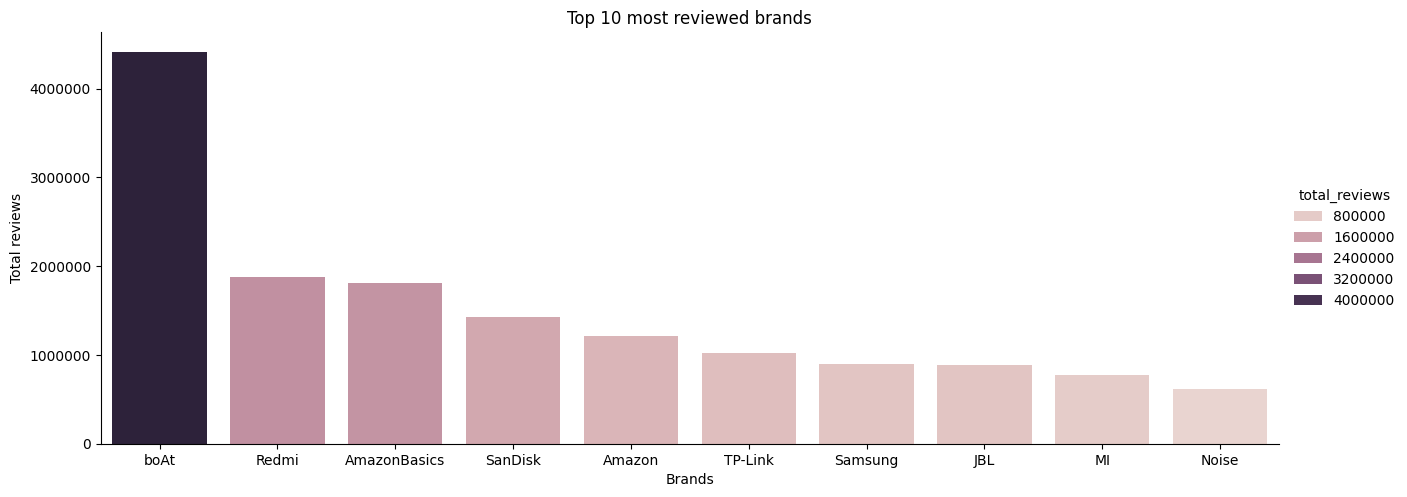

In [5]:
sns.catplot(y="total_reviews", x="brands", hue="total_reviews",data=n_reviews_brand,aspect=2.5,kind="bar")
plt.ticklabel_format(style='plain', axis='y') 
plt.xlabel("Brands")
plt.ylabel("Total reviews")
plt.title("Top 10 most reviewed brands")
plt.show()

FROM THE ABOVE BAR CHART, ITS QUITE OBVIOUS THAT boAt IS THE MOST REVIEWED BY AN ABSURD MARGIN ACROSS ALL BRANDS. THEREFORE, THIS BRANDS PRODUCT IS IN HIGH DEMAND AND MOSTLY WELL RECIEVED BY CUSTOMERS.



**AVERAGE RATINGS ACROSS BRANDS IN RESPECT TO RATING INDEX**

In [6]:
# Averages of the total ratings present within each brands 
brands = (df_3.groupby("brands")
            .agg(mean_rating=("rating", "mean"),total_reviews=("rating_count", "sum"))
            .query("total_reviews >= 10").reset_index()
)            

# Result bias: Larger brands with tons of ratings dominate,but smaller ones with very few ratings can’t shoot up unfairly.
# I need to balances mean rating with scale of reviews using a log transform.
brands["rating_index"] = (brands["mean_rating"] * np.log1p(brands["total_reviews"]))

brand_rating = brands.sort_values("rating_index", ascending=False).reset_index(drop=True).head(10) 
brand_rating

,brands,mean_rating,total_reviews,rating_index
0,boAt,4.080597,4416568.0,62.436700
1,AmazonBasics,4.306061,1808818.0,62.042517
2,SanDisk,4.370588,1426074.0,61.933143
3,TP-Link,4.317647,1027849.0,59.769101
4,Redmi,4.053846,1878482.0,58.561761
5,Amazon,4.140000,1213138.0,57.996108
6,MI,4.271429,774818.0,57.922215
7,Samsung,4.202778,901882.0,57.629498
8,Logitech,4.380000,349817.0,55.911437
9,Fire-Boltt,4.230769,536078.0,55.812463


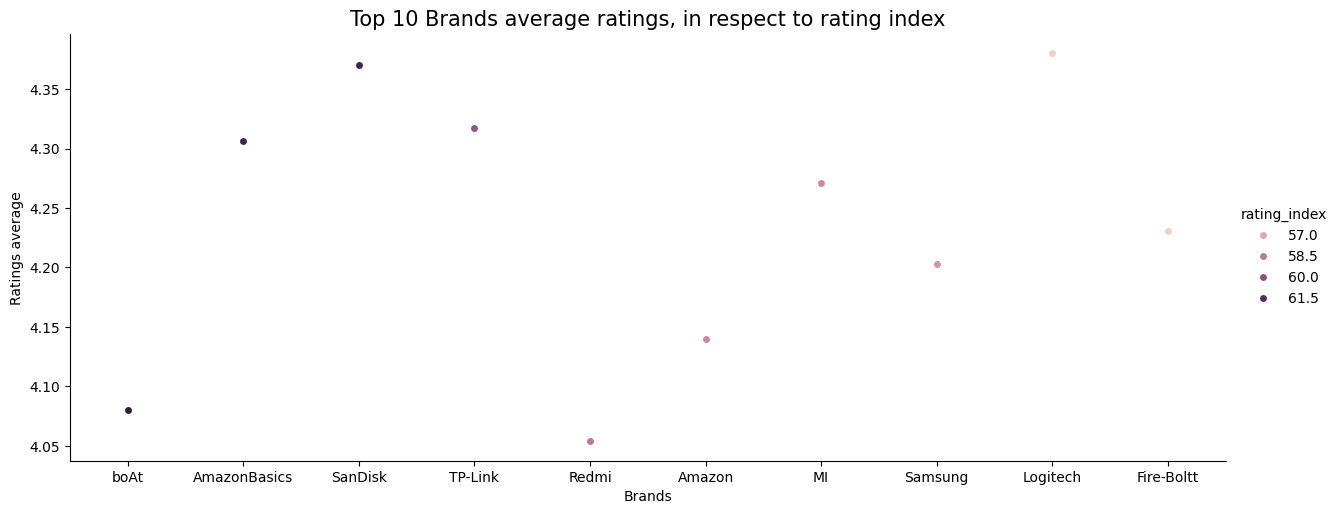

In [7]:
sns.catplot(y = "mean_rating", x = "brands", hue = "rating_index", data = brand_rating, aspect=2.5)
plt.xlabel("Brands", fontsize = 10)
plt.ylabel("Ratings average", fontsize = 10) 
plt.title("Top 10 Brands average ratings, in respect to rating index", fontsize = 15)
plt.show()

In [62]:
# Saving brands rating to a new csv file
brand_rating.to_csv("brand_rating.csv", index=False)

**BRANDS WEIGHTED SATISFACTION SCORE**

In [8]:
# Mapping sentiments to numerical representations
mapping = {"satisfied": 1.0, "Mixed": 0, "dissatisfied": -1.0}
df_3["sentiment_value"] = df_3["customer_sentiment"].map(mapping) 

In [9]:
brand_sentiment = (df_3.groupby("brands")
                  .agg(total_satisfied=("sentiment_value", lambda x: (x == 1).sum()),
                       total_sentiment_score =("sentiment_value", "count"))
                  .query("total_sentiment_score >= 10")      
)           
# Storing the percentage of satisfied customer in a variable        
satisfied_percent = brand_sentiment["total_satisfied"] / brand_sentiment["total_sentiment_score"] * 100
                                                                     
# Final Satisfaction Scoring metric for brands    
brand_sentiment["weighted_satisfaction_score"] = satisfied_percent * np.log1p(brand_sentiment["total_sentiment_score"])

# Top Brands with the most satisfied customer
Top_satisfied_brands = brand_sentiment.sort_values("weighted_satisfaction_score", ascending=False).reset_index()

Top_satisfied_brands

,brands,total_satisfied,total_sentiment_score,weighted_satisfaction_score
0,AmazonBasics,25,33,267.148525
1,pTron,13,13,263.905733
2,Duracell,15,20,228.339183
3,Noise,17,24,228.003704
4,Wayona,17,24,228.003704
5,Portronics,20,31,223.595865
6,STRIFF,9,11,203.310544
7,Classmate,9,11,203.310544
8,Bajaj,15,24,201.179739
9,AGARO,10,14,193.432157


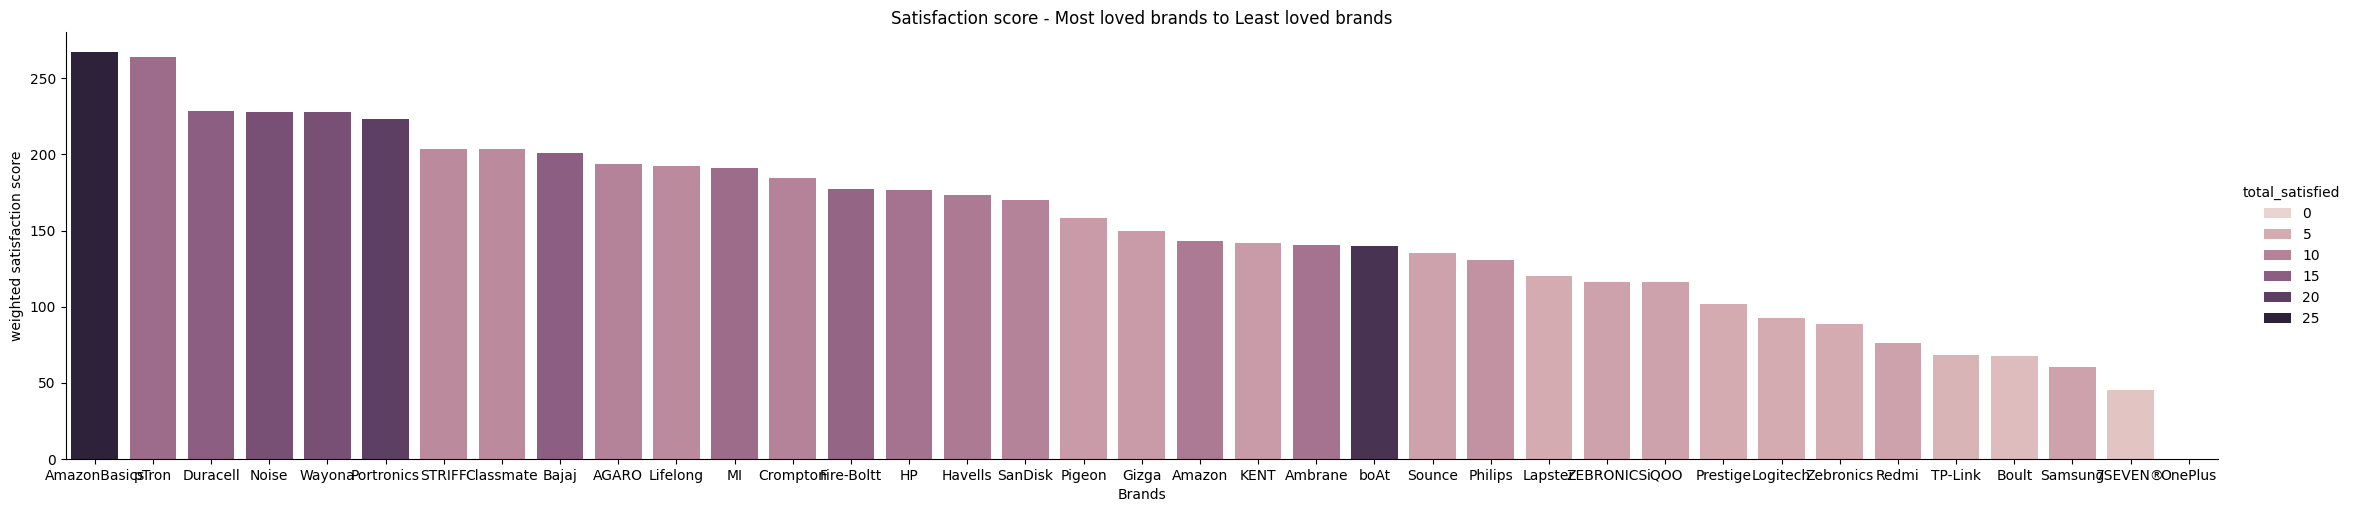

In [10]:
sns.catplot(x="brands", y="weighted_satisfaction_score", data = Top_satisfied_brands, hue = "total_satisfied", aspect = 4.5, kind = "bar")
plt.ticklabel_format(style="plain", axis = "y")
plt.xlabel("Brands")
plt.ylabel("weighted satisfaction score")
plt.title("Satisfaction score - Most loved brands to Least loved brands")
plt.show()

In [61]:
# Saving Top satisifed brands to a new csv
Top_satisfied_brands.to_csv("Top_satisfied_brands.csv", index=False)

### 2. CATEGORY INSIGHTS 
***Compute per category_group:*** 
- n_reviews_category = total ratings across category (sum of rating_count or count of review rows).

- avg_rating_category = mean rating across all category reviews.

- rating_index = Balancing avg_rating_category with volume of ratings by using a log transform.

- percent_satisfied_category = total satisfied reviews / total reviews for category.

- percent_dissatisfied_category = total dissatisfied reviews / total reviews for category

- Weighted_satisfactio_score = percent_satisfied_category * np.log1p(category["total_sentiment_score"])

This formula rewards items that are not only well-liked but are also reviewed or discussed frequently. It's a way to balance the quality of sentiment (the percentage) with the quantity of sentiment (the total score)..


***Deliverables:***

- Scatter: Top 10 most reviewed category (hue=total_reviews)

- Bar: Top 10 avg_rating_category in respect to rating_index (hue=rating_index) (reports/brands_rating_vs_index.png)

- Bar: Weighted satisfaction score across categories

**CSV: reports/category_summary.csv**

In [11]:
df_3["category"].unique()

array(['Computers&Accessories', 'Electronics', 'MusicalInstruments',
       'OfficeProducts', 'Home&Kitchen', 'HomeImprovement', 'Toys&Games',
       'Car&Motorbike', 'Health&PersonalCare'], dtype=object)

**TOTAL REVIEWS ACROSS CATEGORY**

In [12]:
# Total number of reviews across each categories
n_reviews_category = (df_3.groupby("category")
                     .agg(total_reviews = ("rating_count", sum))        
                     .sort_values("total_reviews", ascending = False)
                     .reset_index() 
)

n_reviews_category


C:\Users\OGHENETEGA\AppData\Local\Temp\ipykernel_29128\2808139295.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg(total_reviews = ("rating_count", sum))


,category,total_reviews
0,Electronics,15778848.0
1,Computers&Accessories,7739047.0
2,Home&Kitchen,2991069.0
3,OfficeProducts,149675.0
4,MusicalInstruments,88882.0
5,Toys&Games,15867.0
6,HomeImprovement,8566.0
7,Health&PersonalCare,3663.0
8,Car&Motorbike,1118.0


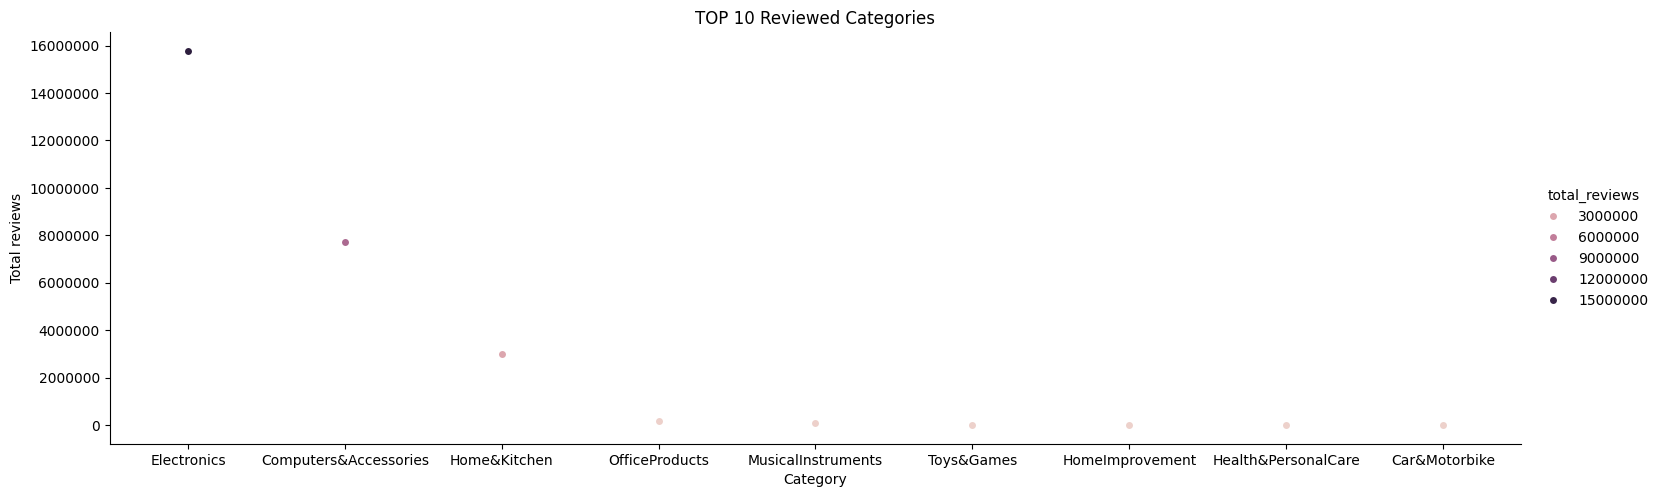

In [13]:
sns.catplot(y = "total_reviews", x = "category", hue = "total_reviews", data = n_reviews_category, aspect = 3.0)
plt.ticklabel_format(style="plain", axis="y")
plt.xlabel("Category")
plt.ylabel("Total reviews")
plt.title("TOP 10 Reviewed Categories") 
plt.show()

In [14]:
# Mean ratings across each categories
# What it does: Just takes the arithmetic mean of ratings per category.
avg_rating_category = (df_3.groupby("category")
                     .agg(Average_rating = ("rating", "mean"))        
                     .sort_values("Average_rating", ascending = False)
                     .reset_index() 
)

# "Result bias: Categories with small review counts can float to the top if their handful of reviews happen to be good."
avg_rating_category


,category,Average_rating
0,OfficeProducts,4.309677
1,Toys&Games,4.300000
2,HomeImprovement,4.250000
3,Computers&Accessories,4.154967
4,Electronics,4.081749
5,Home&Kitchen,4.042857
6,Health&PersonalCare,4.000000
7,MusicalInstruments,3.900000
8,Car&Motorbike,3.800000


**AVERAGE RATINGS ACROSS CATEGORIES IN RESPECT TO RATING INDEX**

In [15]:
# What it does: Balances mean rating with scale of reviews using a log transform.
category = df_3.groupby("category").agg(avg_rating =("rating", "mean"),total_reviews=("rating_count", "sum")).reset_index()

# Result bias: Larger categories with tons of ratings dominate (Electronics, Computers),
# but smaller ones with very few ratings can’t shoot up unfairly.
category["rating_index"] = (category["avg_rating"] * np.log1p(category["total_reviews"]))

avg_category_ratings = category.sort_values("rating_index", ascending=False).reset_index(drop=True)

avg_category_ratings


,category,avg_rating,total_reviews,rating_index
0,Electronics,4.081749,15778848.0,67.651647
1,Computers&Accessories,4.154967,7739047.0,65.905209
2,Home&Kitchen,4.042857,2991069.0,60.283616
3,OfficeProducts,4.309677,149675.0,51.355100
4,MusicalInstruments,3.900000,88882.0,44.440797
5,Toys&Games,4.300000,15867.0,41.589857
6,HomeImprovement,4.250000,8566.0,38.486610
7,Health&PersonalCare,4.000000,3663.0,32.825243
8,Car&Motorbike,3.800000,1118.0,26.676725


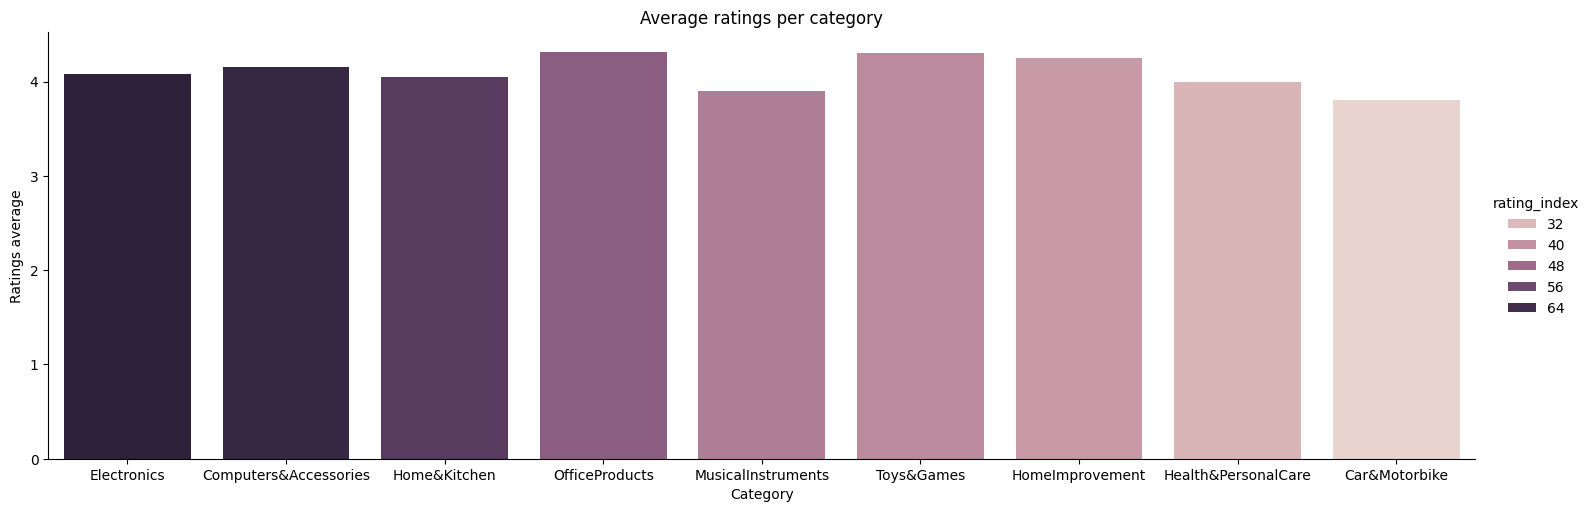

In [16]:
sns.catplot(y="avg_rating", x="category", hue="rating_index",data=avg_category_ratings,aspect=3.0,kind="bar")
plt.ticklabel_format(style='plain', axis='y') 
plt.xlabel("Category")
plt.ylabel("Ratings average")
plt.title("Average ratings per category")
plt.show()

In [60]:
# Saving the average ratings of each category to a new csv
avg_category_ratings.to_csv("avg_category_ratings.csv", index=False)

**WEIGHTED SATISFACTION SCORE ACROSS EACH CATEGORY**

In [17]:
category_sentiment = (df_3.groupby("category")
                  .agg(total_satisfied=("sentiment_value", lambda x: (x == 1).sum()),
                       total_sentiment_score=("sentiment_value", "count"))
                  .query("total_sentiment_score >= 10")      
)           
# Storing the percentage of satisfied customer in a variable        
percent_satisfied_category = (category_sentiment["total_satisfied"] / category_sentiment["total_sentiment_score"] * 100)
                                                                     
# Final Satisfaction Scoring metric for each categories   
category_sentiment["weighted_satisfaction_score"] = percent_satisfied_category * np.log1p(category_sentiment["total_sentiment_score"])

# Top categories with the most satisfied customer
Top_satisfied_category = category_sentiment.sort_values("weighted_satisfaction_score", ascending=False).reset_index()

Top_satisfied_category

,category,total_satisfied,total_sentiment_score,weighted_satisfaction_score
0,Computers&Accessories,291,448,396.683853
1,Home&Kitchen,258,437,359.087524
2,Electronics,226,521,271.445849
3,OfficeProducts,22,30,251.825728


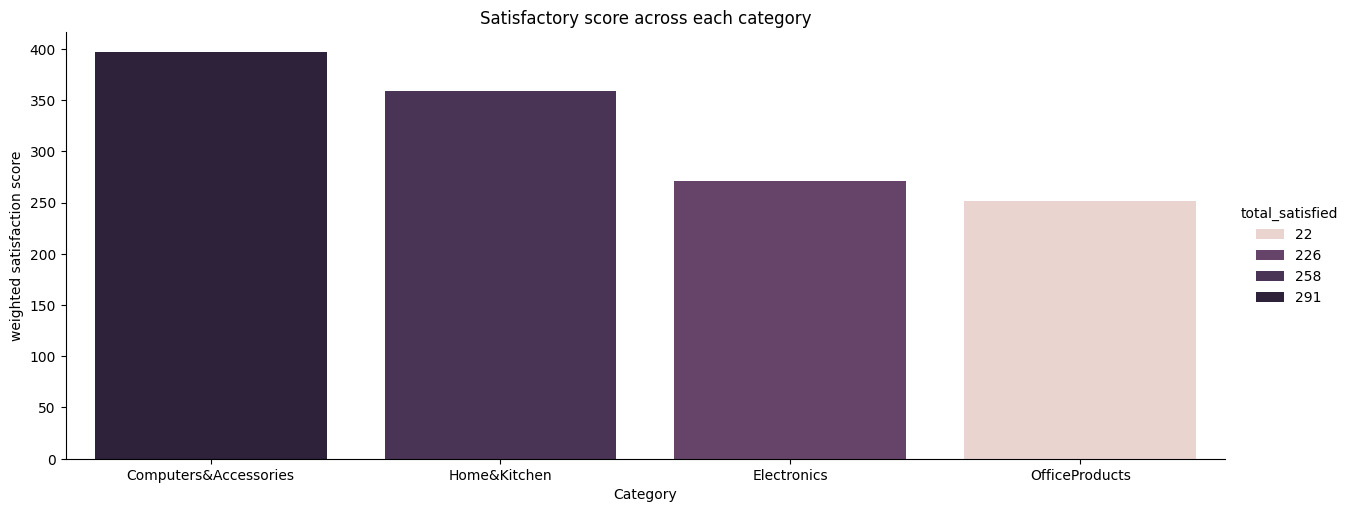

In [18]:
sns.catplot(y="weighted_satisfaction_score", x="category", hue="total_satisfied",data=Top_satisfied_category,aspect=2.5,kind="bar")
plt.ticklabel_format(style='plain', axis='y') 
plt.xlabel("Category")
plt.ylabel("weighted satisfaction score")
plt.title("Satisfactory score across each category")
plt.show()

In [59]:
# Saving Top satisifed categories to a new csv
Top_satisfied_category.to_csv("Top_satisfied_category.csv", index=False)


### 3) Price_Tier & Discount Analysis 

**Goal: Test if value perception changes across price bands.**

**Metrics:**

- avg_rating & satisfactory_score 


**Deliverables:** 

CSV: reports/price_tier_summary.csv

Scatter plot - avg_rating for both price_tier and discount_tier

Heatmap: Price_tier against total_satisfied vs total_sentiment_score vs satisfaction_score 

Heatmap: discount_tier against total_satisfied vs total_sentiment_score vs satisfaction_score 


**AVERAGE RATINGS FOR EACH PRICE TIERS**

In [19]:
# Mean ratings across each price tiers
# What it does: Just takes the arithmetic mean of ratings per category.
price_avg_rating = (df_3.groupby("price_tier")
                     .agg(Average_rating = ("rating", "mean"),total_reviews = ("rating_count", sum))                       
                     .sort_values("Average_rating", ascending = False)
                     .reset_index() 
)

price_avg_rating

C:\Users\OGHENETEGA\AppData\Local\Temp\ipykernel_29128\3067847413.py:4: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg(Average_rating = ("rating", "mean"),total_reviews = ("rating_count", sum))


,price_tier,Average_rating,total_reviews
0,High,4.105738,8556346.0
1,Mid,4.104933,8563437.0
2,Low,4.082863,9656952.0


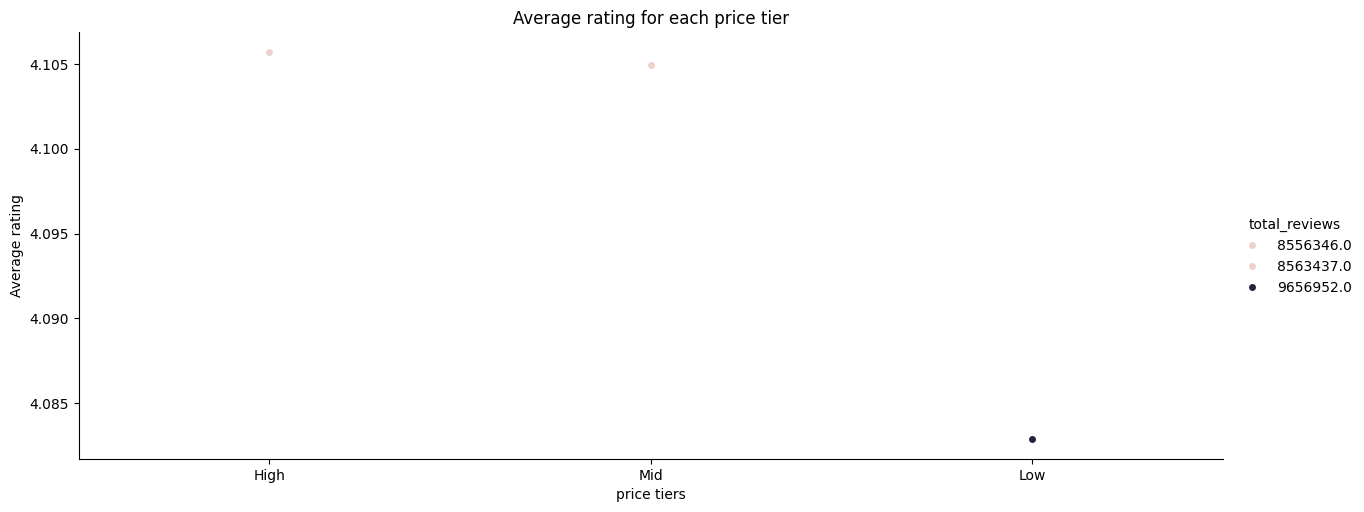

In [20]:
sns.catplot(y="Average_rating", x="price_tier", hue="total_reviews", data= price_avg_rating, aspect=2.5)
plt.xlabel("price tiers")
plt.ylabel("Average rating")
plt.title("Average rating for each price tier") 
plt.show()

**AVERAGE RATING ACROSS DISCOUNT TIER**

In [21]:
# Mean ratings across each discount tiers
# What it does: Just takes the arithmetic mean of ratings per category.
discount_avg_rating = (df_3.groupby("discount_tier")
                     .agg(Average_rating = ("rating", "mean"),total_reviews = ("rating_count", sum))                       
                     .sort_values("Average_rating", ascending = False)
                     .reset_index() 
)

discount_avg_rating

C:\Users\OGHENETEGA\AppData\Local\Temp\ipykernel_29128\4088997736.py:4: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg(Average_rating = ("rating", "mean"),total_reviews = ("rating_count", sum))


,discount_tier,Average_rating,total_reviews
0,Low,4.147755,8799711.0
1,Mid,4.079291,8595314.0
2,High,4.062642,9381710.0


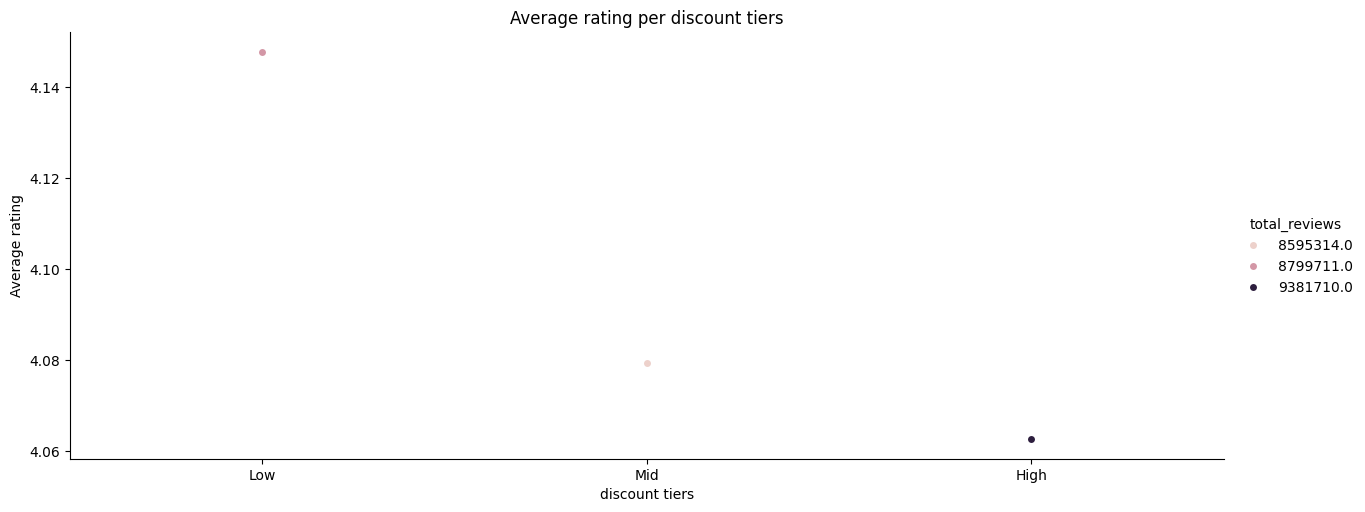

In [22]:
sns.catplot(y="Average_rating", x="discount_tier", hue="total_reviews", data= discount_avg_rating, aspect=2.5)
plt.xlabel("discount tiers")
plt.ylabel("Average rating")
plt.title("Average rating per discount tiers") 
plt.show()

**SATISFACTORY RATE ACROSS PRICE TIERS**

In [23]:
price_sentiment = (df_3.groupby("price_tier")
                  .agg(total_satisfied=("sentiment_value", lambda x: (x == 1).sum()),total_sentiment_score=("sentiment_value", "count"))
                  .query("total_sentiment_score >= 10")      
)           
# Storing the percentage of satisfied customer in a variable        
price_satisfied_prcnt = (price_sentiment["total_satisfied"] / price_sentiment["total_sentiment_score"] * 100)
                                                                     
# Final Satisfaction Scoring metric for each price tier   
price_sentiment["satisfactory_score"] = price_satisfied_prcnt * np.log1p(price_sentiment["total_sentiment_score"])

# Price Tier with the most satisfied customer
price_sentiment = price_sentiment.sort_values("satisfactory_score", ascending=False).reset_index()

price_sentiment 

,price_tier,total_satisfied,total_sentiment_score,satisfactory_score
0,Low,333,523,398.676239
1,Mid,250,438,347.288779
2,High,217,482,278.228966


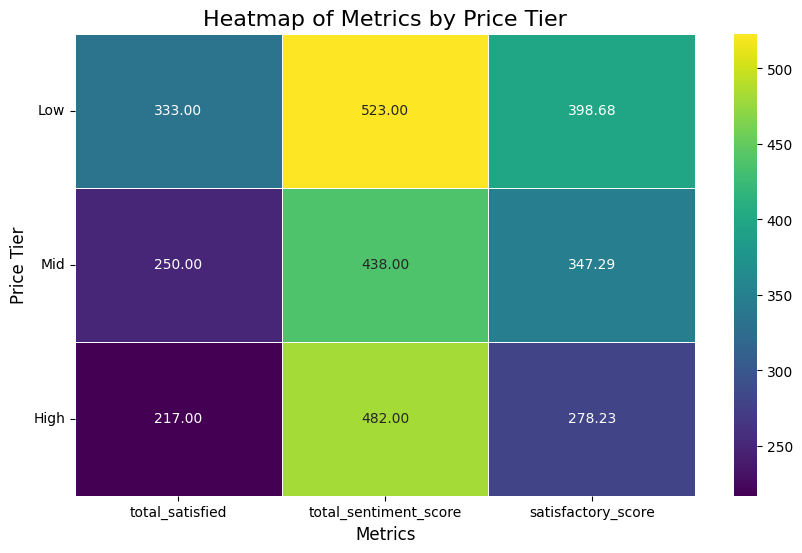

In [24]:
# Set the 'price_tier' as the index for plotting the heatmap
price_sentiment_heatmap = price_sentiment.set_index('price_tier')

# Create the heatmap using the final DataFrame
plt.figure(figsize=(10, 6))
sns.heatmap(price_sentiment_heatmap, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Heatmap of Metrics by Price Tier', fontsize=16)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Price Tier', fontsize=12)
plt.yticks(rotation=0)
plt.show()

In [57]:
price_sentiment.to_csv("price_sentiment.csv", index = False)

**DISCOUNT TIERS SATISFACTORY RATES**

In [25]:
discount_sentiment = (df_3.groupby("discount_tier")
                  .agg(total_satisfied=("sentiment_value", lambda x: (x == 1).sum()),
                        total_sentiment_score=("sentiment_value", "count"))
                  .query("total_sentiment_score >= 10")    
)           
# Storing the percentage of satisfied customer in a variable        
satisfied_prcnt = (discount_sentiment["total_satisfied"] / discount_sentiment["total_sentiment_score"] * 100)
                                                                     
# Final Satisfaction Scoring metric for each price tier   
discount_sentiment["satisfactory_score"] = satisfied_prcnt * np.log1p(discount_sentiment["total_sentiment_score"])

# Price Tier with the most satisfied customer
discount_sentiment = discount_sentiment.sort_values("satisfactory_score", ascending=False).reset_index()

discount_sentiment

,discount_tier,total_satisfied,total_sentiment_score,satisfactory_score
0,High,270,435,377.232967
1,Mid,301,526,358.636381
2,Low,229,482,293.614899


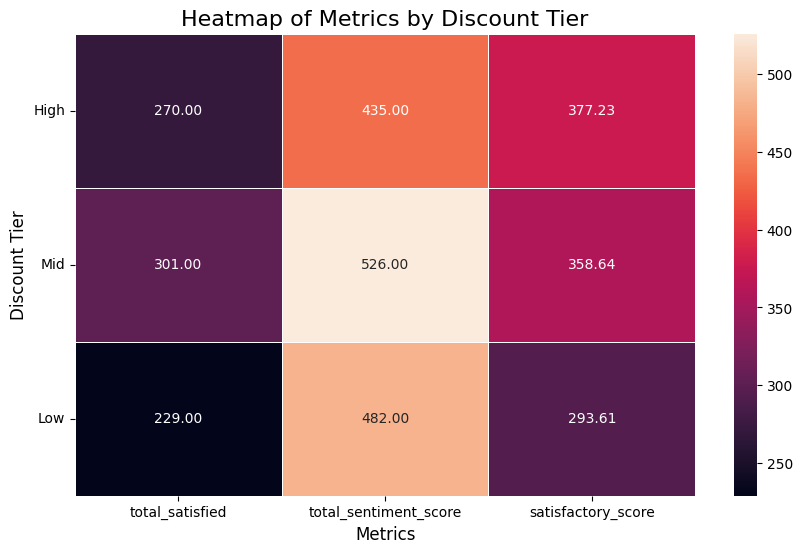

In [26]:
# Set the 'price_tier' as the index for plotting the heatmap
discount_sentiment_heatmap = discount_sentiment.set_index('discount_tier')

# Create the heatmap using the final DataFrame
plt.figure(figsize=(10, 6))
sns.heatmap(discount_sentiment_heatmap, annot=True, fmt=".2f", linewidths=.5)
plt.title('Heatmap of Metrics by Discount Tier', fontsize=16)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Discount Tier', fontsize=12)
plt.yticks(rotation=0)
plt.show()

In [55]:
discount_sentiment.to_csv("discount_sentiment.csv", index = False)

### 5) Ultra-Discount Deep Dive

Goal: Audit extreme cases (>90% discount).

Analysis:

- Export all ultra_discount == True.

- avg_rating, satisfaction_index, 

- frequency by brand/category.

Deliverables:

CSV: reports/ultra_discount_cases.csv

Bar: ultra-discount products satisfaction vs normal products

Narration line:
“These ultra-discount products are often one-time clearance items, dragging down brand trust.”

In [27]:
# Discount >90% saved within a variable called ultra_discnt   
ultra_discnt = df_3.query("ultra_discount == True")

In [28]:
ultra_discnt["rating_count"]

334    13937.0
364    13937.0
368    13937.0
372    13937.0
380    13937.0
695     4426.0
Name: rating_count, dtype: float64

In [29]:
# Average ratings & ratings distribution of ultra_discount across brands and category
ultra_disc_summary = (ultra_discnt.groupby("brands")
            .agg(category = ("category", "sum"), mean_rating =("rating", "mean"), total_rating =("rating_count", "sum"),
                total_ultra_disct = ("ultra_discount", "count"),total_satisfied=("sentiment_value", lambda x: (x == 1).sum()))
            .sort_values("total_ultra_disct", ascending = False).reset_index()
)            

ultra_disc_summary["category"] = ultra_discnt["category"].unique()

ultra_disc_summary

,brands,category,mean_rating,total_rating,total_ultra_disct,total_satisfied
0,Fire-Boltt,Electronics,4.2,69685.0,5,0
1,rts,Computers&Accessories,4.3,4426.0,1,0


Conclusion - The ultra discount was only present within a small subset of brands and appeared more on Electronics and computer category

In [103]:
ultra_disc_summary.to_csv("ultra_disc_summary.csv", index=False)

### 6) Sentiment Analytics

**Goal: compute the satisfaction and dissatisfaction rate against the total sentiment**

This tells us what brands and category satisfies the most customers and which doesnt

**Workflow**

- brands satisfaction % and dissatisfaction %

- category satisfaction% and dissatisfaction %

**Deliverables:**

- CSV: reports/final_sentiment_analysis.csv

- scatter plot: Customer Satisfaction & Dissatisfaction Rates by Brand  

- Heatmap: Heatmap of each Category, showing the total_satisfaction vs total_dissatisfaction vs total_sentiment vs satisfaction% vs dissatisfaction%   

In [30]:
brand_sentiment = (df_3.groupby("brands").agg(total_satisfied=("sentiment_value", lambda x: (x == 1).sum()),
                                             total_dissatisfied=("sentiment_value", lambda x: (x == -1).sum()),
                                             total_sentiment = ("sentiment_value", "count"))
                                        .query("total_sentiment >= 10").reset_index()
)                                        

satisfied_percent = brand_sentiment["total_satisfied"] / brand_sentiment["total_sentiment"]*100

dissatisfied_percent = brand_sentiment["total_dissatisfied"] / brand_sentiment["total_sentiment"]*100

brand_sentiment["satisfied_%"] = satisfied_percent

brand_sentiment["dissatisfied_%"] = dissatisfied_percent

brand_sentiment.sort_values("satisfied_%", ascending =False, inplace=True)

brand_sentiment


,brands,total_satisfied,total_dissatisfied,total_sentiment,satisfied_%,dissatisfied_%
36,pTron,13,0,13,100.000000,0.000000
7,Classmate,9,0,11,81.818182,0.000000
26,STRIFF,9,1,11,81.818182,9.090909
3,AmazonBasics,25,0,33,75.757576,0.000000
9,Duracell,15,0,20,75.000000,0.000000
16,Lifelong,9,0,12,75.000000,0.000000
1,AGARO,10,0,14,71.428571,0.000000
19,Noise,17,0,24,70.833333,0.000000
31,Wayona,17,0,24,70.833333,0.000000
8,Crompton,10,0,15,66.666667,0.000000


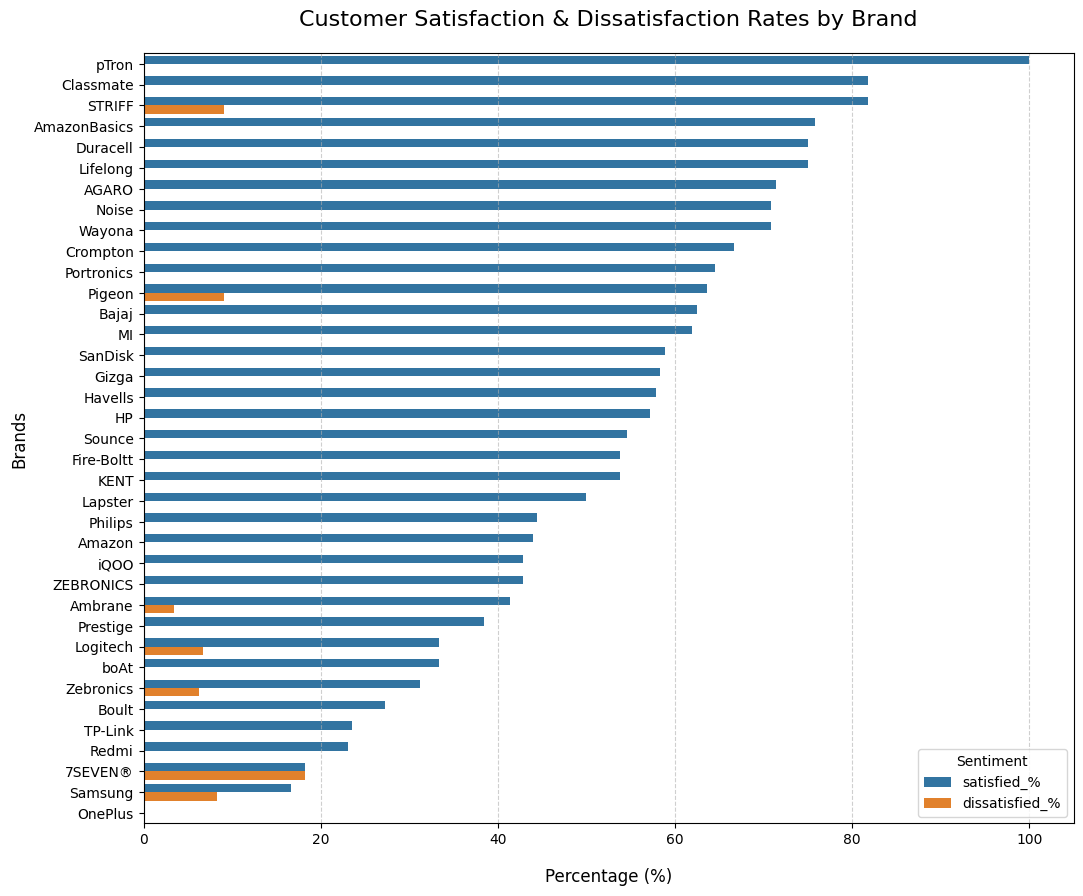

In [31]:
# Melt the DataFrame to long-form for seaborn
df_melted = brand_sentiment.melt(id_vars='brands', 
                          value_vars=['satisfied_%', 'dissatisfied_%'],
                          var_name='Sentiment', 
                          value_name='Percentage')

# Create a figure and axes
plt.figure(figsize=(12, 10))

# Create a grouped bar chart using Seaborn
sns.barplot(x='Percentage', y='brands', hue='Sentiment', data=df_melted)

# Customize the plot
plt.title('Customer Satisfaction & Dissatisfaction Rates by Brand', fontsize=16, pad=20)
plt.xlabel('Percentage (%)', fontsize=12, labelpad=15)
plt.ylabel('Brands', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend(title='Sentiment')
plt.show()


In [107]:
brand_sentiment.to_csv("brands_sentiment.csv")

In [32]:
category_sentiment = df_3.groupby("category").agg(total_satisfied=("sentiment_value", lambda x: (x == 1).sum()),
                                                  total_dissatisfied=("sentiment_value", lambda x: (x == -1).sum()),
                                    total_sentiment = ("sentiment_value", "count")).query("total_sentiment >= 10")

sat_percent = category_sentiment["total_satisfied"] / category_sentiment["total_sentiment"]*100

dissat_percent = category_sentiment["total_dissatisfied"] / category_sentiment["total_sentiment"]*100

category_sentiment["satisfied_%"] = sat_percent

category_sentiment["dissatisfied_%"] = dissat_percent

category_sentiment 

,total_satisfied,total_dissatisfied,total_sentiment,satisfied_%,dissatisfied_%
category,,,,,
Computers&Accessories,291,5,448,64.955357,1.116071
Electronics,226,17,521,43.378119,3.262956
Home&Kitchen,258,10,437,59.038902,2.288330
OfficeProducts,22,1,30,73.333333,3.333333


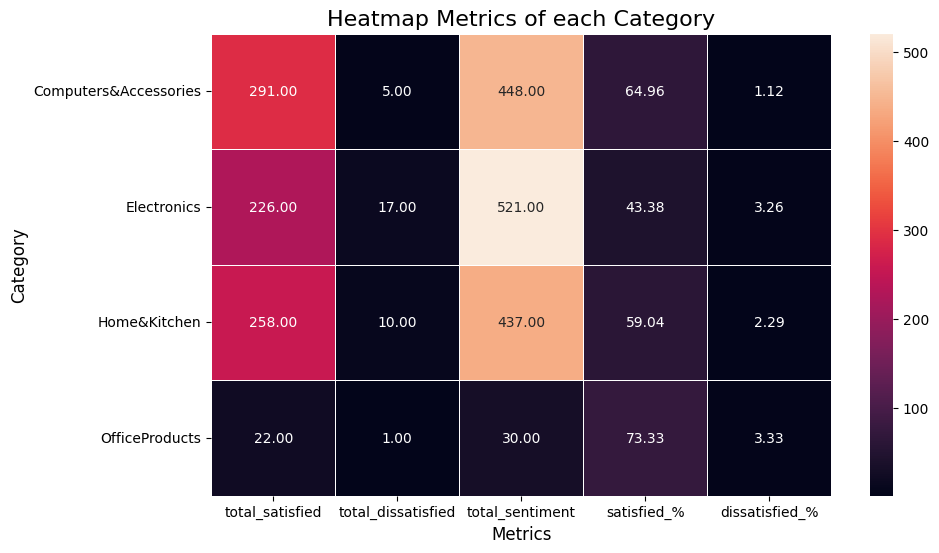

In [33]:
# Create the heatmap using the final DataFrame
plt.figure(figsize=(10, 6))
sns.heatmap(category_sentiment, annot=True, fmt=".2f", linewidths=.5)
plt.title('Heatmap Metrics of each Category', fontsize=16)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.yticks(rotation=0)
plt.show()

In [108]:
category_sentiment.to_csv("category_sentiment.csv")